## Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

Prepare the input data by crappifying images.

In [3]:
from crappify import *

Uncomment the first time you run this notebook. # 처음에 돌려보고 해제함.

In [10]:
# il = ImageList.from_folder(path_hr)
# parallel(crappifier(path_lr, path_hr), il.items)

For gradual resizing we can change the commented line here.

In [11]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34 # gan에 사용할 model 세팅.

## Pre-train generator

Now let's pretrain the generator.

In [12]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [13]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [14]:
data_gen = get_data(bs,size) # batch size 만큼식 size*size 크기의 이미지를 불러옴.

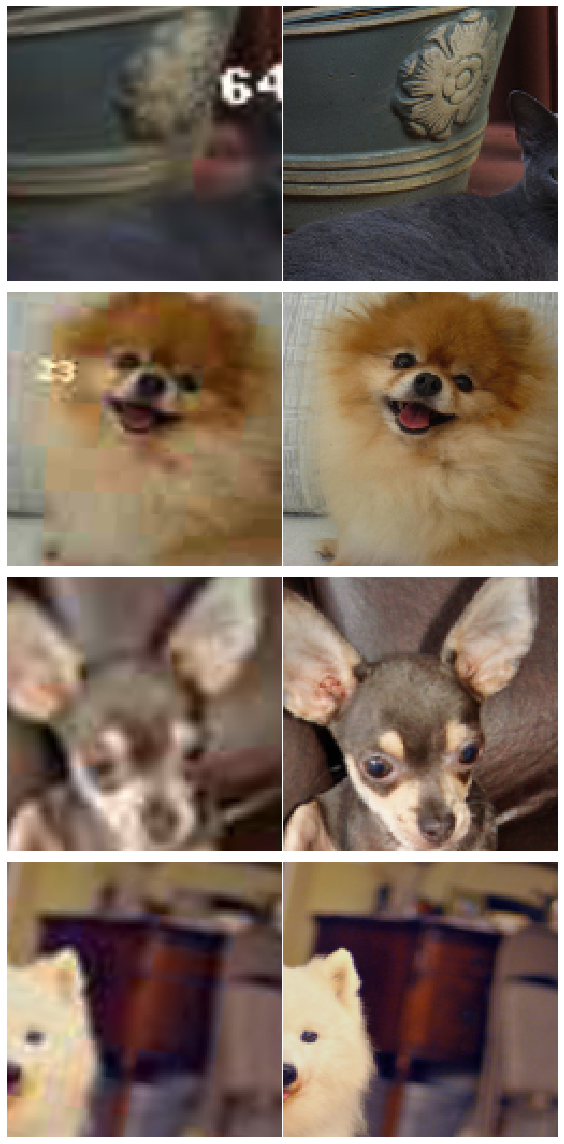

In [15]:
data_gen.show_batch(4)

In [16]:
wd = 1e-3

In [17]:
y_range = (-3.,3.)

In [18]:
loss_gen = MSELossFlat()

In [19]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)
# super-resolution을 위한 GAN에서 쓰일 generator network를 만들기 위해 U-net architecture를 적용.

In [20]:
learn_gen = create_gen_learner()

In [21]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [22]:
learn_gen.unfreeze()

In [23]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

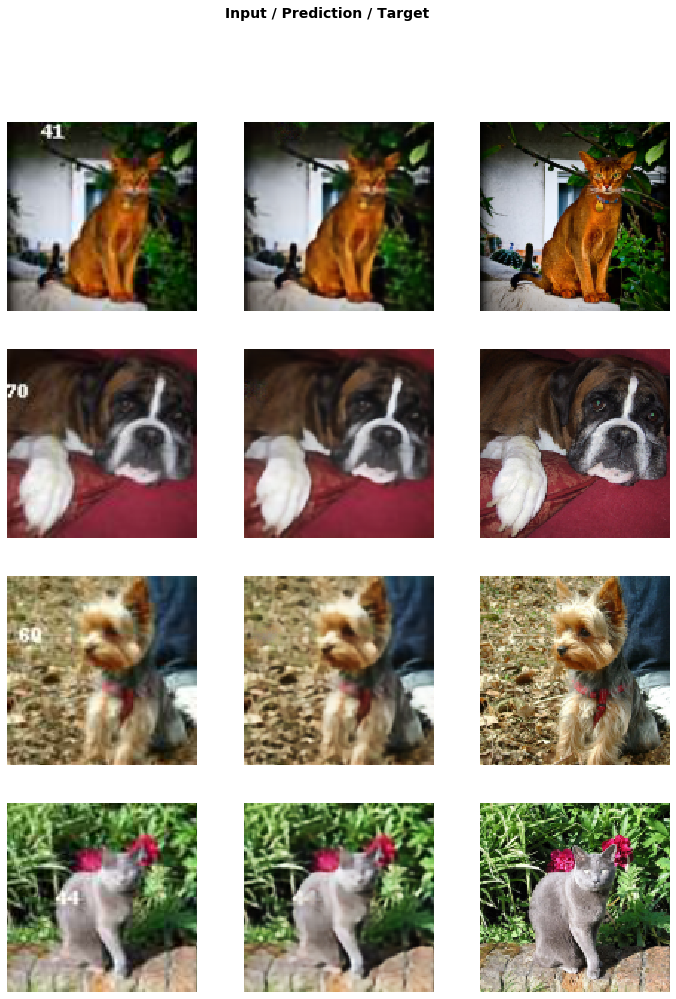

In [24]:
learn_gen.show_results(rows=4)

In [25]:
learn_gen.save('gen-pre2')

## Save generated images

In [26]:
learn_gen.load('gen-pre2');

In [27]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [28]:
# shutil.rmtree(path_gen)

In [29]:
path_gen.mkdir(exist_ok=True)

In [30]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [31]:
save_preds(data_gen.fix_dl) 

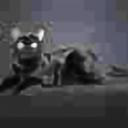

In [32]:
PIL.Image.open(path_gen.ls()[0]) # GAN을 통해 만들어낸 binary image를 이미지 형태로 읽어옴.

## Train critic

In [33]:
learn_gen=None
gc.collect() # memory release

42

Pretrain the critic on crappy vs not crappy.

In [34]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data # 생성된 이미지와 생성되기 이전의 원본 이미지에 대해서 분류하는 모델(discrinimator)를 만든다.

In [35]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

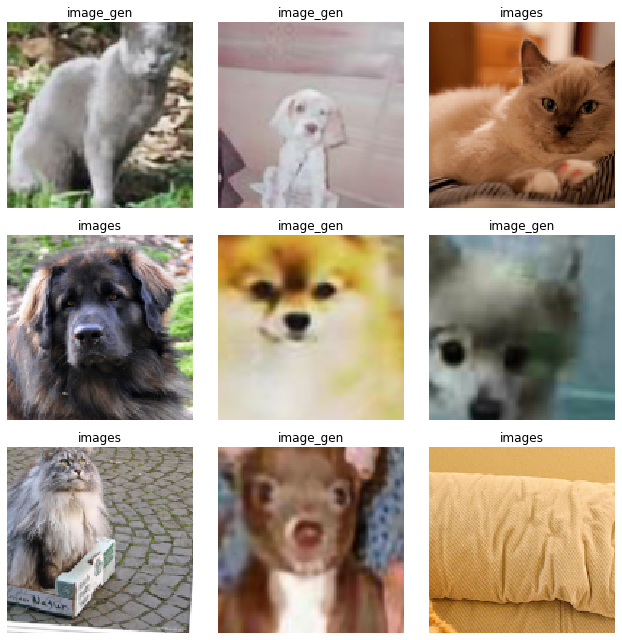

In [36]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [37]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [38]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [39]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [40]:
learn_critic.fit_one_cycle(6, 1e-3)

In [41]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [42]:
learn_crit=None
learn_gen=None
gc.collect()

19539

In [43]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [44]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [45]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [46]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

# 이때까지 만들었던 Generative Network와 Discriminator Network를 합쳐서 Generative-Advarsarial Network를 만든다.

In [47]:
lr = 1e-4

In [48]:
learn.fit(40,lr)

In [49]:
learn.save('gan-1c')

In [50]:
learn.data=get_data(16,192)

In [51]:
learn.fit(10,lr/2)

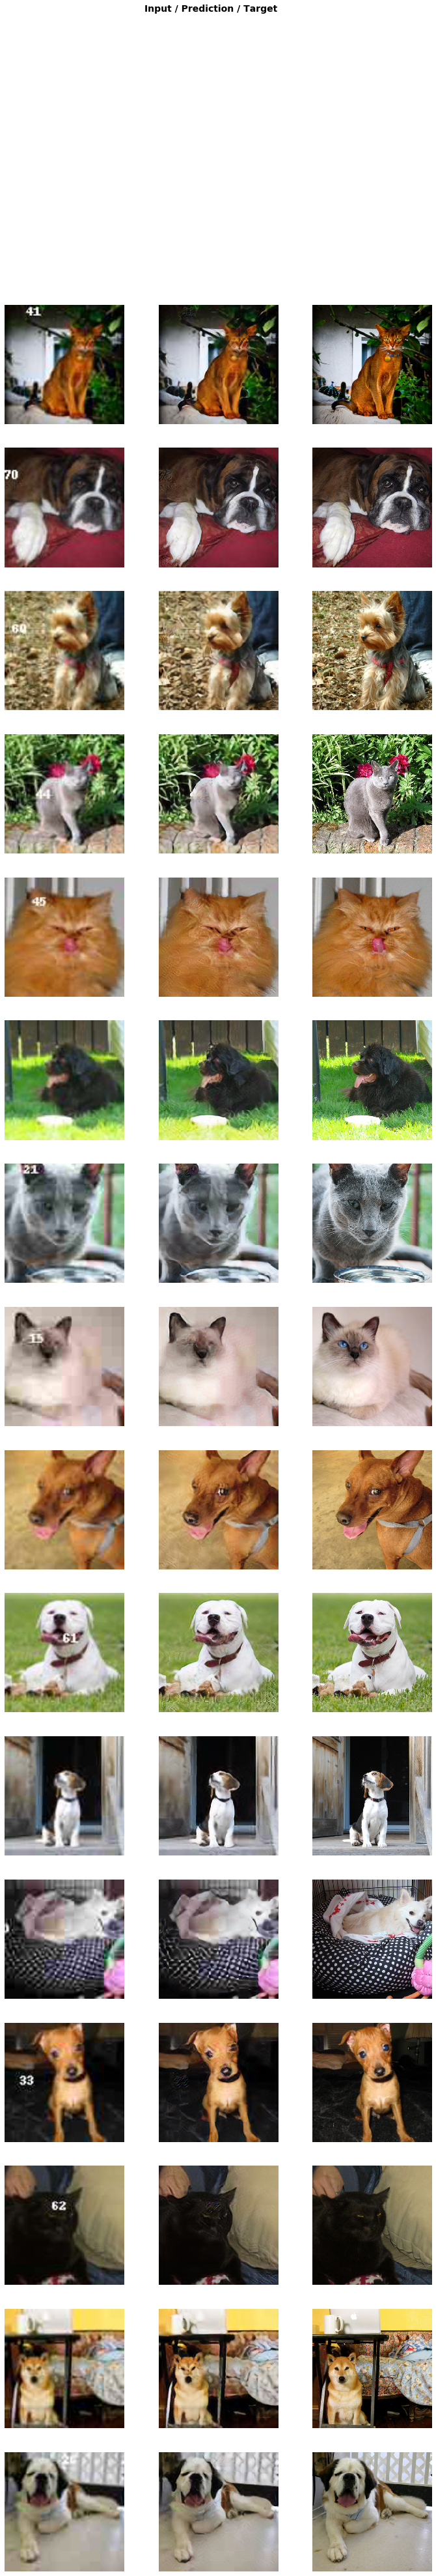

In [52]:
learn.show_results(rows=16)

In [53]:
learn.save('gan-1c')

## fin

## Comment

- super-resolution을 위해서 generator와 discriminator를 U-net과 ResNet을 통해 손쉽게 구현하였다.


- Generator Network는 원본 이미지를 super-resolution을 적용한 모델을 만들기 위해, Discriminator Network는 원래 이미지와 super-resolution이 되고 싶은 이미지를 평가하면서, Generator가 더 좋은 이미지를 만들 수 있게 도와준다.


- GAN을통해 손쉽게 super-resolution 이미지를 생성할 수 있었다. (학습시간도 20분 내외였다)